# **Recommeder System Using Amazon Reviews**

> <center><a href="https://ibb.co/TDbrNvQR"><img src="https://i.ibb.co/dsL7HWN6/Amazon-Above-Fold-Homepage-1.jpg" alt="Amazon-Above-Fold-Homepage-1" border="0"></a>

<a id="introduction"></a>
## 1. Introduction

<div align='left'><font size="3"> Amazon uses different recommendation models to provide different suggestions to different users. It currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.
</font></div>

* **Goal:**
<div align='left'><font size="3"> In this project we are going to build recommendation model for the electronics products of Amazon.
</font></div>


* **Attribute Information:**
<div align='left'><font size="3">
<ul>
  <li>userId : Every user identified with a unique id (First Column)</li>
  <li>productId : Every product identified with a unique id(Second Column)</li>
  <li>Rating : Rating of the corresponding product by the corresponding user(Third Column)</li>
  <li>timestamp : Time of the rating ( Fourth Column)</li>
</ul>
</font></div>


<a id="data_acquisition"></a>
## 2. Data Acquisition

### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import io
sns.set_style('white')
%matplotlib inline

### Load Dataset

In [23]:
# Define the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Recomendation_System_Amazon_Product/amazon.zip"  # Change to your ZIP file path

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()  # List of files inside ZIP

    # Look for CSV file inside the ZIP
    csv_file = None
    for file in file_list:
        if file.endswith('.csv'):
            csv_file = file
            break  # Assuming there's only one CSV file

    if csv_file is None:
        print("No CSV file found inside the ZIP archive.")
    else:
        # Read the CSV file from ZIP
        with zip_ref.open(csv_file) as file:
            # Load CSV into a DataFrame and specify column names
            df = pd.read_csv(io.BytesIO(file.read()))

In [24]:
df.head()

,userId,productId,rating,timestamp
0,A5KPODJB1EUC4,B0092KRAVQ,5.0,1392422400
1,A2ZYEJTUAN7DFH,B00006BBAB,5.0,1403827200
2,A3IT5YOH6MQTWM,B00007KDVJ,3.0,1170115200
3,A1R7D4XHWMK8X8,B00BIP816Q,5.0,1376092800
4,A3A64RN8R59K35,B00008AWL0,5.0,1258243200


<a id="eda"></a>
## 3. EDA

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250001 entries, 0 to 250000
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     250001 non-null  object
 1   productId  250001 non-null  object
 2   rating     250001 non-null  object
 3   timestamp  250001 non-null  object
dtypes: object(4)
memory usage: 7.6+ MB


In [12]:
print("Total number of users   :", df.userId.nunique())
print("Total number of products  :", df.productId.nunique())

Total number of users   : 234717
Total number of products  : 86863


In [13]:
# Check missing value
df.isnull().sum()

,0
userId,0
productId,0
rating,0
timestamp,0


In [14]:
# Check Duplicate data
df[df.duplicated()].any()

,0
userId,False
productId,False
rating,False
timestamp,False


### 3.1 Data Visualization

In [16]:
# Convert 'rating' column to numeric (float)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
productId,,,
0511189877,5.000000,1,5.000000
0594033926,5.000000,1,5.000000
0594514789,5.000000,1,5.000000
0972683275,4.702703,37,4.702703
1400501466,2.833333,6,2.833333
1400501474,5.000000,1,5.000000
1400501520,5.000000,3,5.000000
1400501741,5.000000,1,5.000000
1400501776,4.666667,6,4.666667


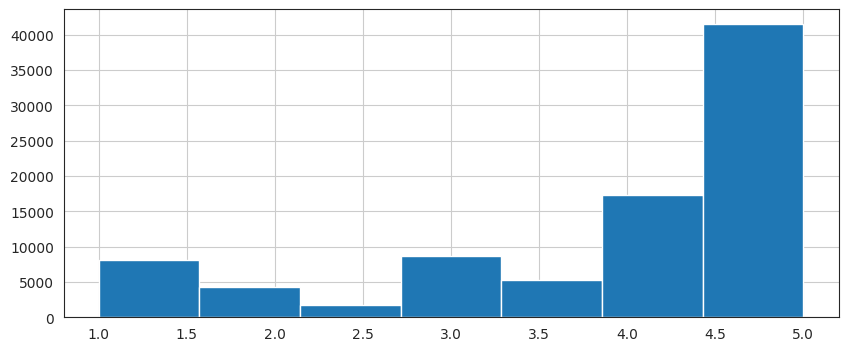

In [18]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=7)
plt.show()

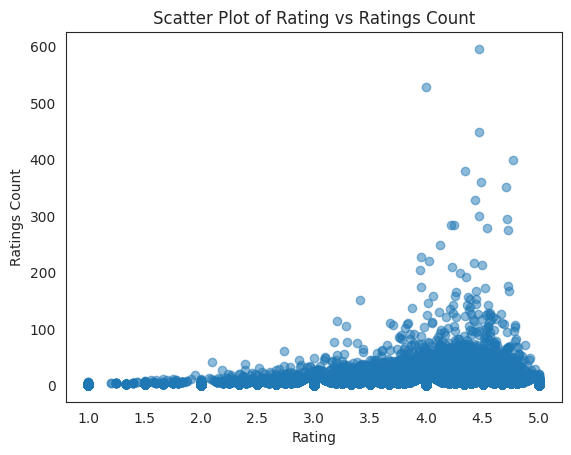

In [21]:
plt.scatter(ratings['rating'], ratings['ratings_count'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Ratings Count')
plt.title('Scatter Plot of Rating vs Ratings Count')
plt.show()

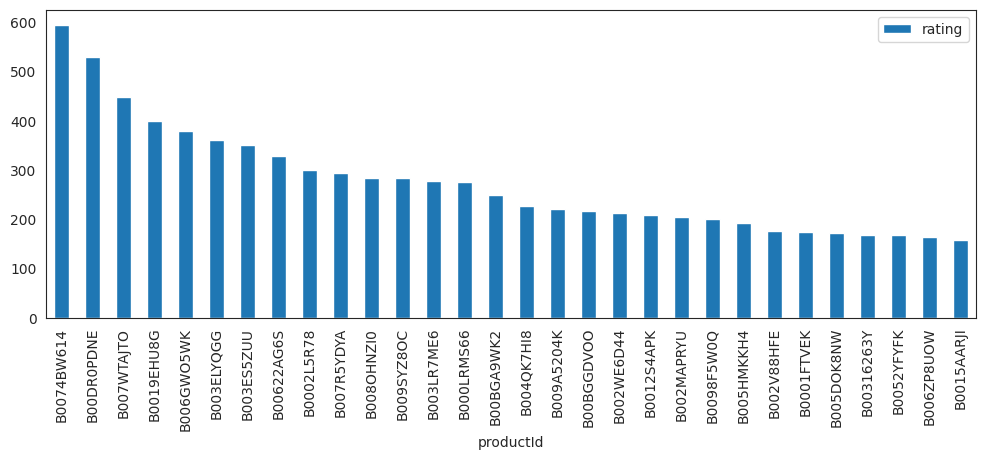

In [22]:
# top 30 products
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))
plt.show()

# Type of Recommender System

# Popular-Based
This is the baseline approach, which represents the most common and intuitive recommendation you’ll come across. Examples of this type of recommendation include the IMDb top-rated movies, Top 10 trending movies on Netflix, and similar lists. These recommendations are typically shown to new users who don't have enough personal data or interaction history. Since there’s limited information about the user, a safe choice is to recommend what’s popular or widely liked by others.

## Limitation:
The primary limitation of this method is that all users receive the same recommendation set. These suggestions are not personalized to the individual, so they may not align with the unique preferences of each user.

## Example Illustration:
Here’s an example of a movie recommendation list based on popularity:<br>
> <center><img src="https://miro.medium.com/max/646/1*7v-Ha1BOzh2r2y_96WceIg.png" width="500px"></center>


### **How the Weighted Rating System Works**

The weighted rating system calculates a product's score by combining the average rating of the product with the number of votes it has received. This approach ensures that products with fewer votes but high ratings don’t unfairly appear at the top, while considering the global popularity of products.

#### **Weighted Rating Formula**:

$$
WR = \left(\frac{v}{v + m}\right) \times R + \left(\frac{m}{v + m}\right) \times C
$$

Where:
- **R** is the average rating of the product.
- **v** is the number of votes the product has received.
- **m** is the minimum number of votes required for a product to be listed among popular items (typically determined by the 80th percentile of total votes).
- **C** is the average rating across the entire dataset.

In [ ]:
vote_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
vote_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = vote_averages.mean()
print("Average rating of product across the whole dataset is",C)

Average rating of product across the whole dataset is 3.876852202014646


In [ ]:
m = vote_counts.quantile(0.95)
print("Minimum votes required to be listed in the chart is",m)

Minimum votes required to be listed in the chart is 4.0


In [ ]:
ratings.head()

,rating,ratings_count,ratings_average
productId,,,
0899336795,1.000000,1,1.000000
0972683275,4.666667,3,4.666667
1400501466,3.666667,3,3.666667
1400501520,5.000000,1,5.000000
1400501776,5.000000,1,5.000000


In [ ]:
qualified = ratings[(ratings['ratings_count'] >= m) & (ratings['ratings_count'].notnull()) & (ratings['ratings_average'].notnull())][['ratings_count', 'ratings_average']]

In [ ]:
qualified['ratings_count'] = qualified['ratings_count'].astype('int')
qualified['ratings_average'] = qualified['ratings_average'].astype('int')
qualified.head().sort_values(by='ratings_count', ascending=False)

,ratings_count,ratings_average
productId,,
B00001P4ZH,13,4
B00000K2YR,6,3
1400532655,4,4
B00000J1V5,4,4
B00001P4XA,4,3


In [ ]:
qualified.shape

(2119, 2)

In [ ]:
def weighted_rating(x):
    v = x['ratings_count']
    R = x['ratings_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('wr', ascending=False).head(20)

## Top 10 Products for recommendation using Popular-based method

In [ ]:
qualified.head(10)

,ratings_count,ratings_average,wr
productId,,,
B000B9RI14,16,5,4.775370
B00EYW9DSU,12,5,4.719213
B00017LSPI,10,5,4.679101
B001MSU1FS,10,5,4.679101
B004C3AW40,9,5,4.654416
B00483WRZ6,9,5,4.654416
B009X3UW2G,9,5,4.654416
B001MSU1HG,9,5,4.654416
B000CSOXTO,9,5,4.654416


Text(0, 0.5, 'Count')

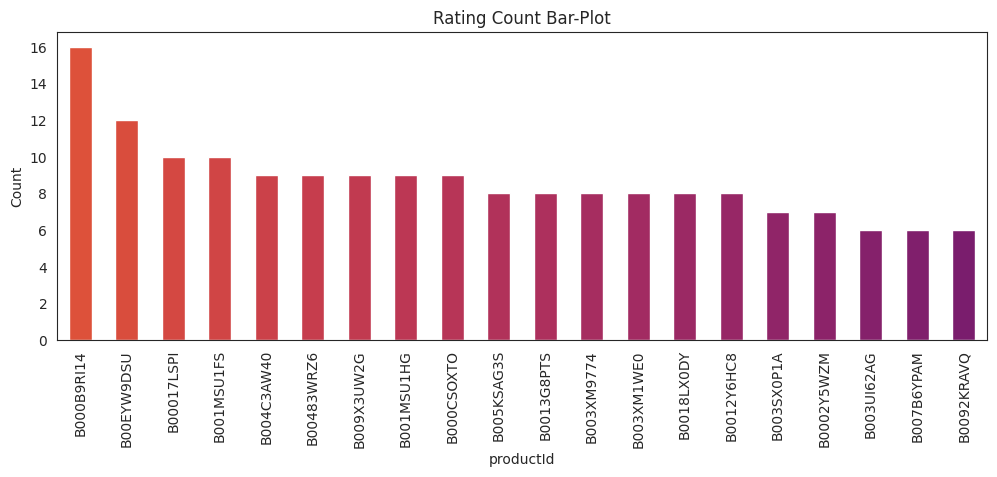

In [ ]:
# Add color
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

rating_plot_count = qualified['ratings_count'].plot.bar(figsize=(12, 4),color=color)
rating_plot_count.set_title("Rating Count Bar-Plot")
rating_plot_count.set_xlabel("productId")
rating_plot_count.set_ylabel("Count")

Text(0, 0.5, 'rating')

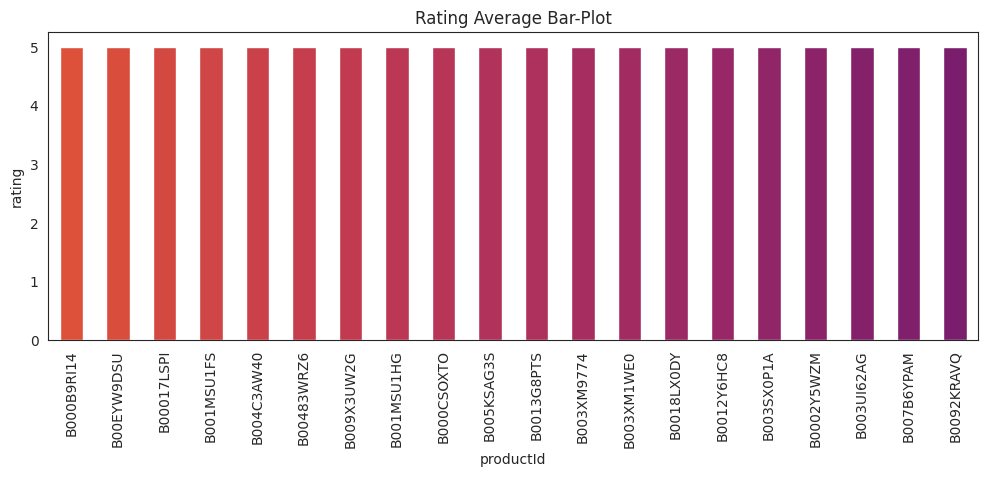

In [ ]:
rating_plot_avg = qualified['ratings_average'].plot.bar(figsize=(12, 4),color=color)
rating_plot_avg.set_title("Rating Average Bar-Plot")
rating_plot_avg.set_xlabel("productId")
rating_plot_avg.set_ylabel("rating")

Text(0, 0.5, 'rating')

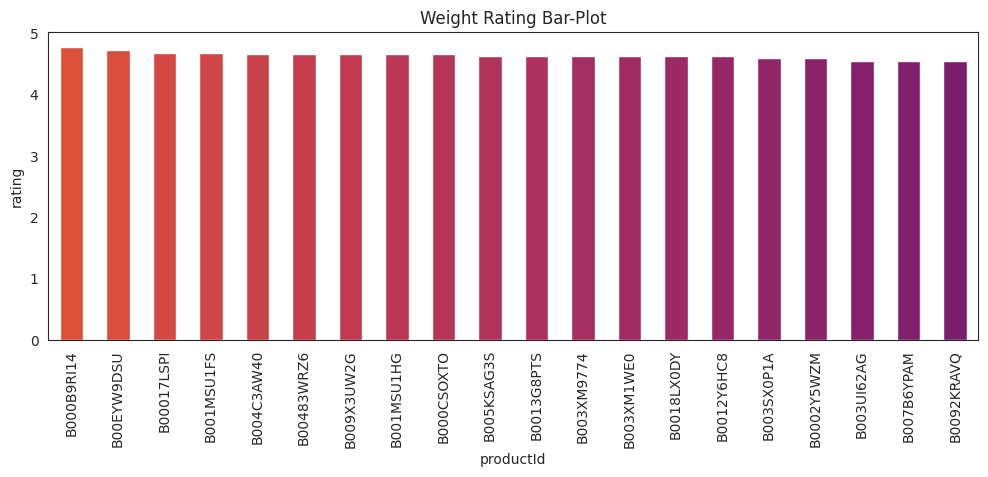

In [ ]:
wr_plot = qualified['wr'].plot.bar(figsize=(12, 4),color=color)
wr_plot.set_title("Weight Rating Bar-Plot")
wr_plot.set_xlabel("productId")
wr_plot.set_ylabel("rating")

# **Hybrid Recommender System**

A **Hybrid Recommender System** combines multiple recommendation techniques (such as content-based filtering and collaborative filtering) to improve the accuracy and effectiveness of recommendations. By using the strengths of both methods, a hybrid system can overcome the limitations of individual models.

#### **Hybrid Approach:**
- The hybrid system combines both methods by either blending their results or switching between them based on certain criteria (e.g., if there's not enough information for collaborative filtering, it switches to content-based recommendations).

### **Hybrid Model Equation:**

The combined score for a product recommendation can be represented as:

$$
\text{Hybrid Score} = \alpha \times \text{Content-Based Score} + (1 - \alpha) \times \text{Collaborative Filtering Score}
$$

Where:
- **Content-Based Score** is derived from how similar a product is to a user’s preferences.
- **Collaborative Filtering Score** is based on user behavior similarities.
- **α** is a weighting factor between the two methods, where 0 < α < 1.

In [26]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505169 sha256=27eb20c198d45891791b0d727846877e2d7f194a0a8f0eea450158c3a5c387a1
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [27]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

### Convert the Data to Surprise Dataset Format

In [29]:
# Convert to Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'productId', 'rating']], reader)

### Split the Data into Training and Test Sets

In [30]:
# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

### Train the Collaborative Filtering Model (SVD)

In [31]:
# Train SVD model (Collaborative Filtering)
svd = SVD()
svd.fit(trainset)

### Make Predictions and Evaluate the Model

In [32]:
# Make predictions
predictions = svd.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
print(f"Collaborative Filtering RMSE: {rmse}")

RMSE: 1.3462
Collaborative Filtering RMSE: 1.3462425218367233


### Define a Hybrid Recommendations function

In [40]:
# Calculate average ratings and count of ratings for each product
popularity = df.groupby('productId').agg({'rating': ['mean', 'count']}).reset_index()
popularity.columns = ['productId', 'avg_rating', 'num_ratings']

# Sort by avg_rating and num_ratings to get the most popular products
popularity_sorted = popularity.sort_values(by=['avg_rating', 'num_ratings'], ascending=False)

# Set alpha for weighting
alpha = 0.5

# Function to get recommendations for a given product ID
def get_recommendations(product_id, top_n=5):
    # Collaborative filtering predictions for all products in testset
    predictions = svd.test(testset)

    # Create dict of predicted ratings for products
    collab_pred = {pred[1]: pred.est for pred in predictions}

    # Popularity score is just the average rating of each product
    popularity_pred = popularity_sorted.set_index('productId')['avg_rating'].to_dict()

    # Hybrid scores calculation
    hybrid_scores = {}
    for product in popularity_pred.keys():
        collab_score = collab_pred.get(product, 0)  # Default to 0 if no collaborative score is available
        popular_score = popularity_pred[product]
        hybrid_score = alpha * collab_score + (1 - alpha) * popular_score
        hybrid_scores[product] = hybrid_score

    # Sort by hybrid score
    sorted_hybrid_scores = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)

    # Get top N recommended products (excluding the input product itself)
    recommended_products = []
    for product, score in sorted_hybrid_scores:
        if product != product_id:  # Exclude the input product itself from the recommendations
            recommended_products.append(product)
            if len(recommended_products) == top_n:
                break

    return recommended_products

### Finally call the function and display the recomendation

In [43]:
# User provides a product ID (example: 'B0092KRAVQ')
input_product_id = 'B0092KRAVQ'

# Get top 5 recommended product IDs
recommended_products = get_recommendations(input_product_id, top_n=5)
print(f"Top 5 recommended products based on product ID '{input_product_id}':")
print(recommended_products)

Top 5 recommended products based on product ID 'B0092KRAVQ':
['B002HZW6K8', 'B0052SCU8U', 'B003FVVMS0', 'B00D6XSRL2', 'B0029N3U8K']
